<div style="padding:16px 18px;border:1px solid rgba(0,0,0,.10);border-radius:16px;background:#ffffff;">
  <div style="font-size:28px;font-weight:800;line-height:1.15;">
    Approaching_DS · <span style="color:#009BC8;">Basis: Connecting a free LLM service</span>
  </div>
  <div style="margin-top:6px;color:rgba(0,0,0,.65);">
    Subtítulo: Se muestra una conexión a LLM open - source.
  </div>

  <div style="height:4px;background:#009BC8;border-radius:999px;margin:14px 0 12px 0;"></div>

  <table style="width:100%;border-collapse:collapse;">
    <tr>
      <td style="padding:8px 10px;border:1px solid rgba(0,0,0,.08);border-radius:12px;">
        <b>Autor</b><br><span style="color:rgba(0,0,0,.65);">@romarc98</span>
      </td>
      <td style="padding:8px 10px;border:1px solid rgba(0,0,0,.08);border-radius:12px;">
        <b>Fecha</b><br><span style="color:rgba(0,0,0,.65);">2026-Q1</span>
      </td>
      <td style="padding:8px 10px;border:1px solid rgba(0,0,0,.08);border-radius:12px;">
        <b>Status</b><br><span style="color:rgba(0,0,0,.65);">Draft</span>
      </td>
    </tr>
  </table>
  </div>
</div>


<div style="padding:10px 12px;border-radius:14px;border:1px solid rgba(0,155,200,.35);background:rgba(0,155,200,.10);">
  <b style="color:#007FA6;">Info</b><br>
  <span style="color:rgba(0,0,0,.70);">
    Experimentación con el Client de Ollama y la capacidad para llamar a sus "n" modelos open - source.
  
  </span>
</div>


In [1]:
import requests

def check_ollama():
    try:
        r = requests.get("http://localhost:11434/api/version", timeout=2)
        return r.status_code, r.text
    except Exception as e:
        return None, str(e)

check_ollama()


(200, '{"version":"0.13.5"}')

In [2]:
import requests, json, time

BASE = "http://127.0.0.1:11434"

def pull_model(model: str, timeout_s: int = 3600):
    """
    Descarga un modelo en Ollama usando la API HTTP.
    Muestra progreso aproximado si el servidor lo reporta.
    """
    url = f"{BASE}/api/pull"
    payload = {"model": model, "stream": True}

    with requests.post(url, json=payload, stream=True, timeout=timeout_s) as r:
        r.raise_for_status()

        last_print = time.time()
        for line in r.iter_lines():
            if not line:
                continue
            msg = json.loads(line.decode("utf-8"))

            status = msg.get("status", "")
            total = msg.get("total", 0)
            completed = msg.get("completed", 0)

            # Throttle prints
            if time.time() - last_print < 0.05:
                continue
            last_print = time.time()

            if total:
                pct = (completed / total) * 100
                print(f"{model} | {status:20s} | {pct:6.2f}%  ({completed/1e6:,.1f} / {total/1e6:,.1f} MB)", end="\r")
            else:
                # Mensajes sin barra de progreso
                print(f"{model} | {status:20s} | {msg}", end="\r")

    print("\nDescarga finalizada.")

# Ejemplo: modelo ligero para empezar
pull_model("llama3.2")

# pull_model("llama3.1:8b")
# pull_model("qwen2.5:7b-instruct")
# pull_model("mistral:7b-instruct")
# pull_model("gemma2:2b")

llama3.2 | pulling dde5aa3fc5ff | 100.00%  (2,019.4 / 2,019.4 MB)
Descarga finalizada.


In [3]:
import requests, json

BASE = "http://127.0.0.1:11434"  # usa 127.0.0.1 para evitar rarezas con localhost en Windows

def hit(method, path, payload=None, timeout=15):
    url = f"{BASE}{path}"
    try:
        r = requests.request(method, url, json=payload, timeout=timeout)
        ct = r.headers.get("content-type", "")
        text = r.text[:500]
        print(f"{method} {path} -> {r.status_code} | {ct}")
        if text:
            print(text)
        print("-"*80)
        return r
    except Exception as e:
        print(f"{method} {path} -> EXCEPTION: {e}")
        print("-"*80)
        return None

# 1) Nativo
hit("GET", "/api/version")
hit("GET", "/api/tags")

GET /api/version -> 200 | application/json; charset=utf-8
{"version":"0.13.5"}
--------------------------------------------------------------------------------
GET /api/tags -> 200 | application/json; charset=utf-8
{"models":[{"name":"llama3.2:latest","model":"llama3.2:latest","modified_at":"2026-01-07T17:48:35.1496098+01:00","size":2019393189,"digest":"a80c4f17acd55265feec403c7aef86be0c25983ab279d83f3bcd3abbcb5b8b72","details":{"parent_model":"","format":"gguf","family":"llama","families":["llama"],"parameter_size":"3.2B","quantization_level":"Q4_K_M"}}]}
--------------------------------------------------------------------------------


<Response [200]>

In [4]:
import requests

BASE = "http://127.0.0.1:11434"

r = requests.get(f"{BASE}/v1/models", timeout=30)
r.raise_for_status()

models = [m["id"] for m in r.json().get("data", [])]
models

['llama3.2:latest']

In [5]:
import requests

BASE = "http://127.0.0.1:11434"
MODEL = models[0]

payload = {
    "model": MODEL,
    "messages": [
        {"role": "system", "content": "Responde en español, técnico y conciso."},
        {"role": "user", "content": "Qué frameworks existen actuamente para gestionar flujos agénticos? (cita almenos 4)"}
    ],
    "temperature": 0.2,
    "stream": False
}

r = requests.post(f"{BASE}/v1/chat/completions", json=payload, timeout=120)
r.raise_for_status()

j = r.json()
print("MODEL:", MODEL)
print(j["choices"][0]["message"]["content"])


MODEL: llama3.2:latest
Existen varios frameworks para gestionar flujos de agentes, que se enfocan en la modelización y el análisis de sistemas complejos. A continuación, te menciono algunos de los más destacados:

1. **Framework de Flujos de Agentes (AFL)**: Desarrollado por el Instituto Nacional de Investigación en Ciencias Aplicadas y Tecnología Industrial (INCIPI), este framework se enfoca en la modelización de sistemas complejos utilizando flujos de agentes.
2. **Framework de Modelado de Flujos de Agentes (MFSA)**: Propuesto por la Universidad Politécnica de Madrid, este framework utiliza técnicas de modelado para analizar y simular sistemas complejos que involucran flujos de agentes.
3. **Framework de Análisis de Flujos de Agentes (AFS)**: Desarrollado por el Instituto de Investigación en Sistemas Complejos (IISC), este framework se enfoca en la análisis y la evaluación de sistemas complejos que involucran flujos de agentes.
4. **Framework de Modelado de Redes de Agentes (MRA)**: 

In [6]:
# Modelo de visión:
pull_model("moondream")

moondream | writing manifest     | {'status': 'writing manifest'}
Descarga finalizada.


In [ ]:
import base64, requests

BASE = "http://127.0.0.1:11434"
MODEL = "moondream:latest"  # o el tag exacto que te salga en /v1/models

def b64_data_url(path: str) -> str:
    with open(path, "rb") as f:
        b64 = base64.b64encode(f.read()).decode("utf-8")
    return f"data:image/png;base64,{b64}"

img_url = b64_data_url("image.jpg")

payload = {
    "model": MODEL,
    "messages": [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "Describe la imagen y extrae cualquier texto visible."},
                {"type": "image_url", "image_url": {"url": img_url}}
            ]
        }
    ],
    "temperature": 0.2,
    "stream": False
}

r = requests.post(f"{BASE}/v1/chat/completions", json=payload, timeout=180)
r.raise_for_status()
print(r.json()["choices"][0]["message"]["content"])



The image features a tennis match between two players, with the scoreboard displaying their scores and other information. One player is positioned on the left side of the screen, while the other is located more towards the right. Both players are holding tennis rackets in their hands as they compete against each other. The scoreboard shows that one player has an advantage over the other by a significant margin, with their score being 6-2.


In [12]:

# Instalo paquetes:
import sys
!{sys.executable} -m pip uninstall -y fitz
!{sys.executable} -m pip install -U PyMuPDF

Found existing installation: fitz 0.0.1.dev2
Uninstalling fitz-0.0.1.dev2:
  Successfully uninstalled fitz-0.0.1.dev2
   ---------------------------------------- 0.0/18.4 MB ? eta -:--:--
   ------------------- -------------------- 8.9/18.4 MB 56.7 MB/s eta 0:00:01
   ---------------------------------------- 18.4/18.4 MB 49.4 MB/s  0:00:00


In [13]:
import fitz  # PyMuPDF
import base64

doc = fitz.open("pdf.pdf")
page = doc[0]
pix = page.get_pixmap(dpi=200)
img_bytes = pix.tobytes("png")
img_b64 = base64.b64encode(img_bytes).decode("utf-8")
img_url = f"data:image/png;base64,{img_b64}"

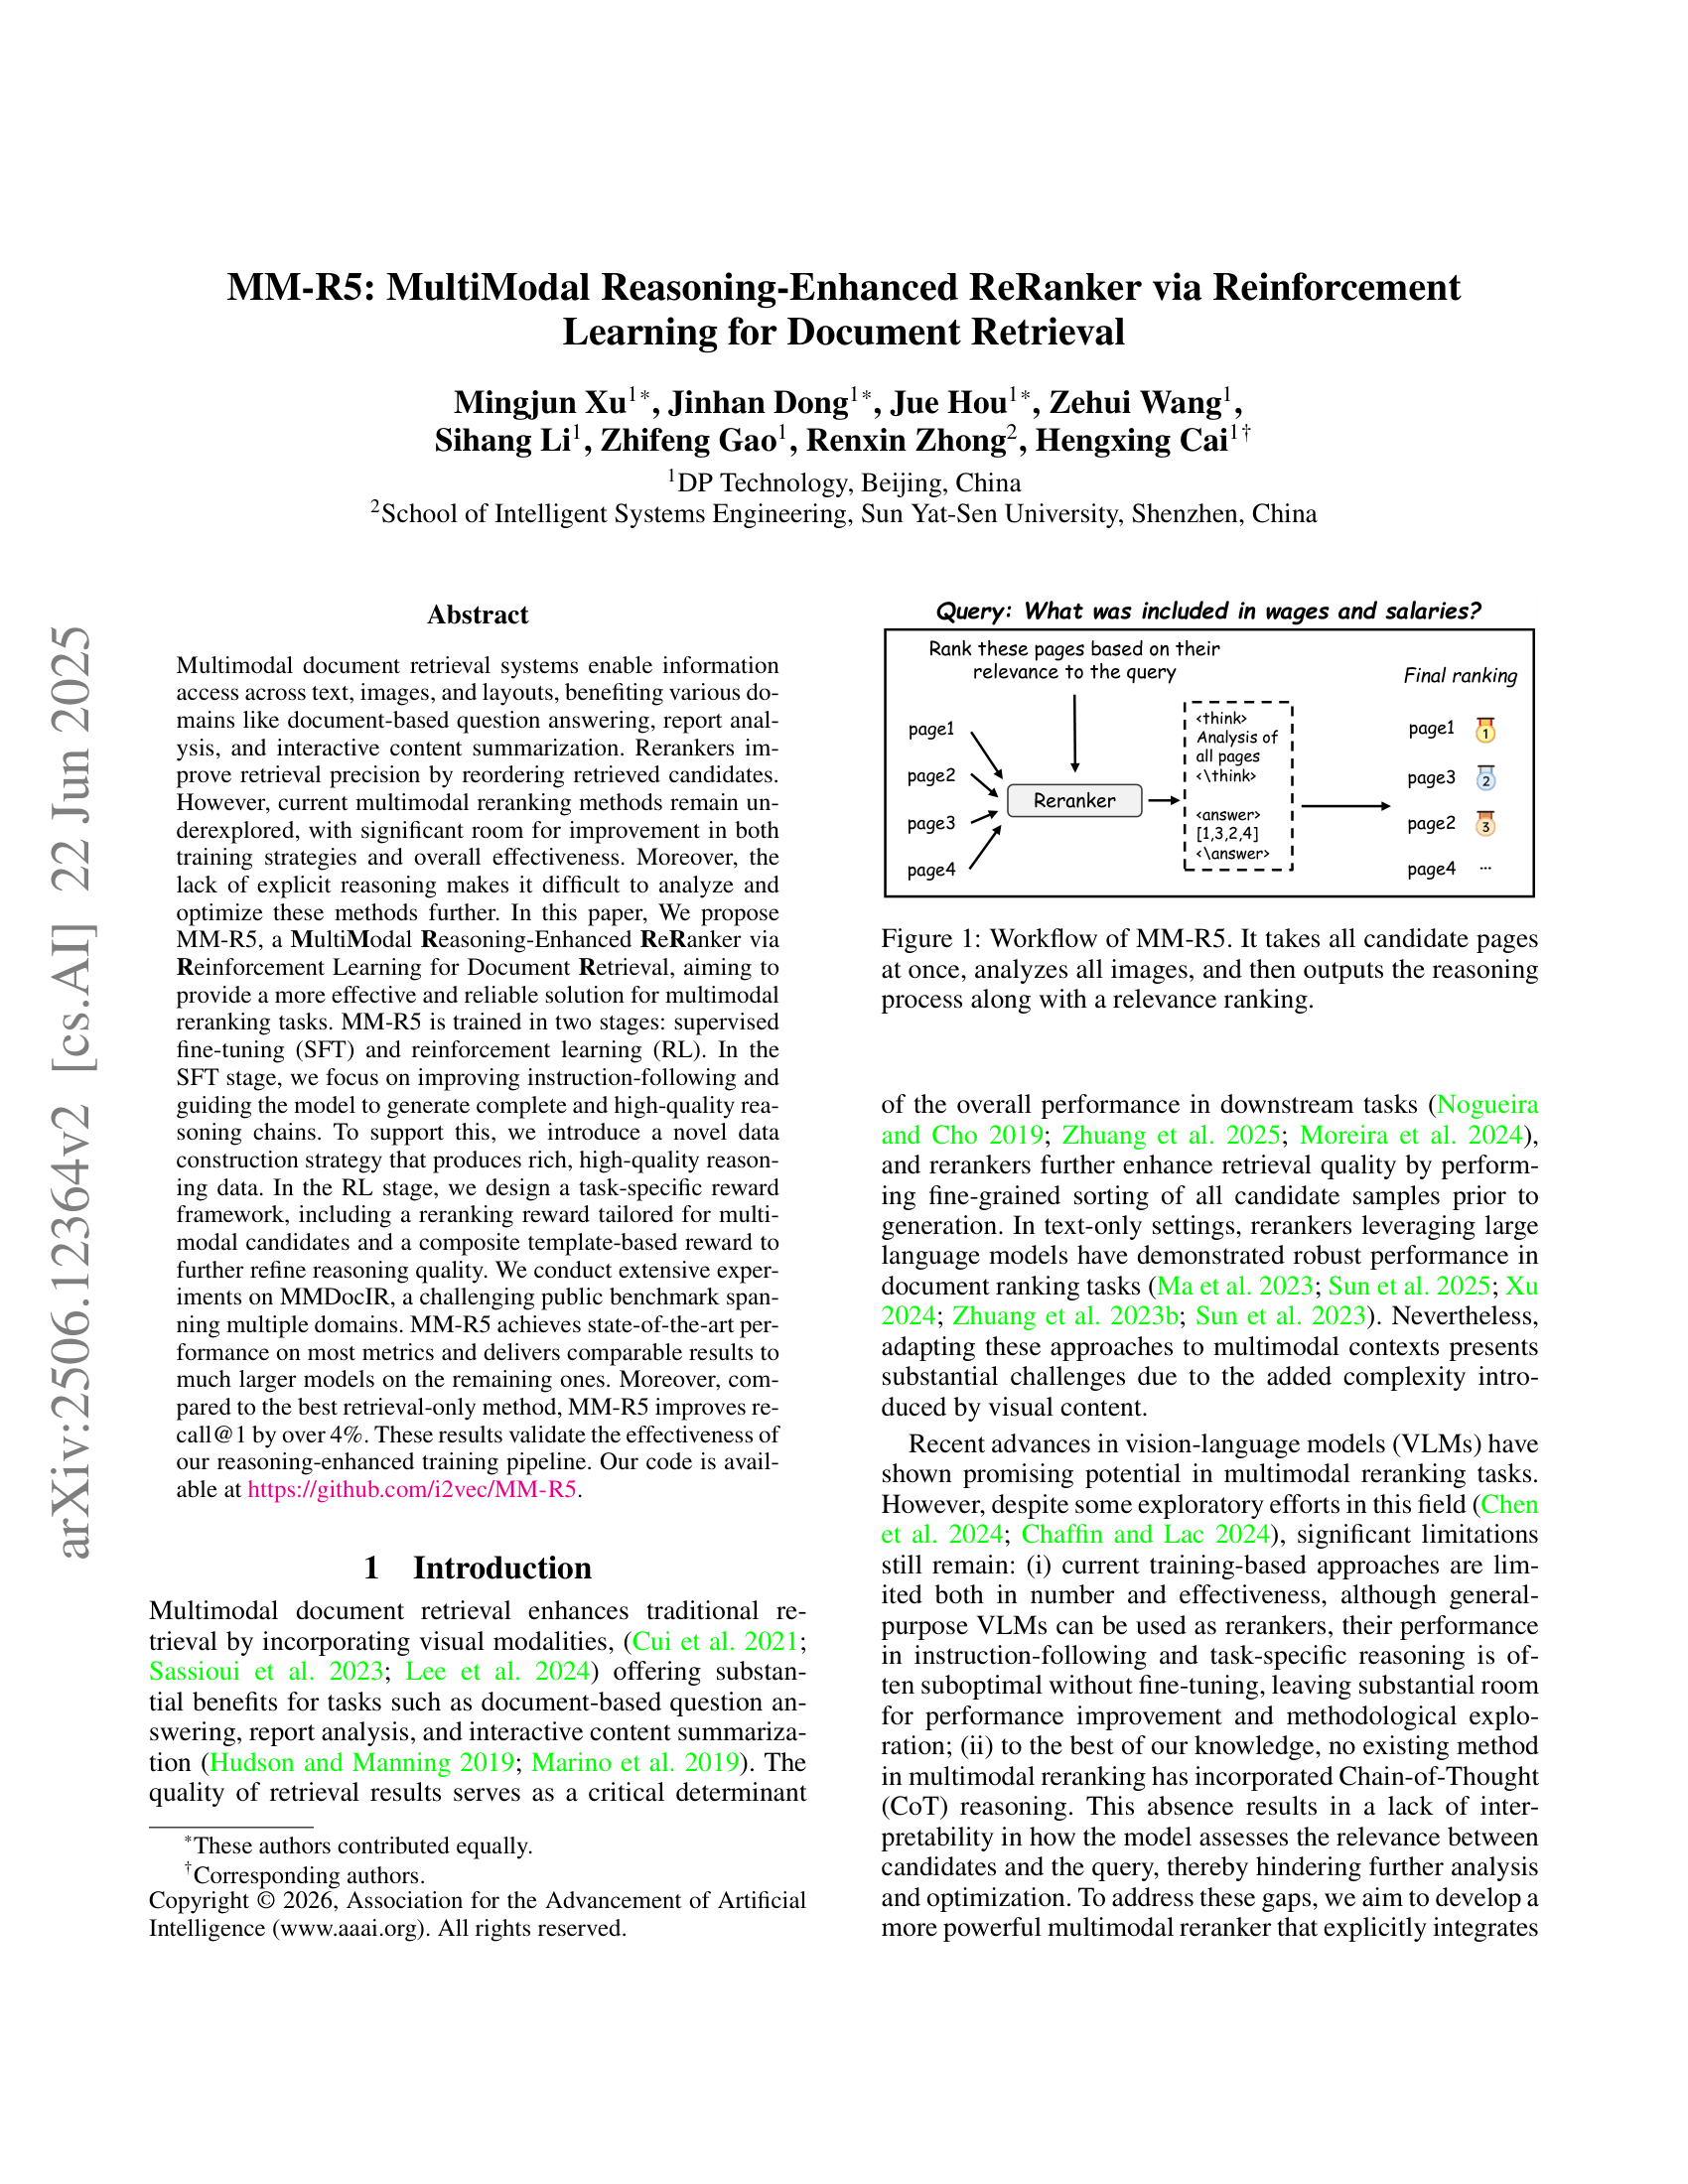

In [16]:
from IPython.display import Image, display

display(Image(data=img_bytes))

In [18]:
payload = {
    "model": MODEL,
    "messages": [
        {"role": "system", "content": (
            "You are an OCR engine. Transcribe ONLY what you see. "
            "Preserve line breaks, spacing as much as possible. "
            "If something is unreadable, write [ILLEGIBLE]. Do not add explanations."
        )},
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "Extract the entire text from the image. Output plain text only."},
                {"type": "image_url", "image_url": {"url": img_url}}
            ]
        }
    ],
    "temperature": 0.0,
    "max_tokens": 4000, 
    "stream": False
}

r = requests.post(f"{BASE}/v1/chat/completions", json=payload, timeout=180)
r.raise_for_status()
print(r.json())


{'id': 'chatcmpl-845', 'object': 'chat.completion', 'created': 1767805921, 'model': 'moondream:latest', 'system_fingerprint': 'fp_ollama', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': '\nThe image shows a page of paper with some writing on it, and there is also a picture present in the scene. The writing appears to be in Chinese, which suggests that this could be an academic or research paper written in Chinese.'}, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 749, 'completion_tokens': 49, 'total_tokens': 798}}


<section style="font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Arial, sans-serif; line-height: 1.45;">
  <h2 style="margin: 0 0 10px 0;">Comparativa técnica: 
  API keys, ejecución local con Ollama y consumo de modelos vía Hugging Face</h2>

  <p style="margin: 0 0 14px 0;">
    En esta sección distingo tres capas conceptuales que a menudo se confunden en conversaciones informales: (i) el mecanismo de autenticación
    (<em>API key</em>), (ii) el plano de ejecución del modelo (local vs remoto) y (iii) el operador de la infraestructura (autogestionado vs
    gestionado por un tercero). Esta descomposición permite comparar alternativas de forma rigurosa en términos de coste marginal, privacidad,
    reproducibilidad y complejidad operacional.
  </p>

  <h3 style="margin: 18px 0 8px 0;">1. API key: credencial de autenticación y control de acceso</h3>
  <p style="margin: 0 0 10px 0;">
    Una <strong>API key</strong> no es un modelo ni un entorno de ejecución; es una <strong>credencial</strong> (secreto) utilizada para autenticar
    solicitudes a un servicio, asociarlas a una identidad (cuenta/organización), aplicar límites de uso y, en su caso, imputar costes. En la práctica,
    una API key habilita el consumo programático de un endpoint remoto (p. ej., OpenAI, Google, Hugging Face). Por tanto, su existencia es ortogonal
    al hecho de ejecutar el modelo localmente o de consumirlo como servicio.
  </p>
  <ul style="margin: 0 0 12px 18px;">
    <li><strong>Función principal:</strong> autenticación, trazabilidad y facturación/quotas.</li>
    <li><strong>Riesgo:</strong> si la clave se filtra, un tercero puede consumir recursos bajo mi identidad (impacto económico y/o reputacional).</li>
    <li><strong>Buena práctica:</strong> gestión como secreto (variables de entorno, vault), rotación y mínimos privilegios.</li>
  </ul>

  <h3 style="margin: 18px 0 8px 0;">2. Ollama en local: inferencia autogestionada con API HTTP (incluida compatibilidad OpenAI)</h3>
  <p style="margin: 0 0 10px 0;">
    <strong>Ollama</strong> proporciona un runtime para ejecutar modelos localmente (CPU/GPU) y exponerlos como un servicio HTTP en la máquina
    del usuario (por ejemplo, <code>localhost</code>). El rasgo diferencial es que la <strong>infraestructura de inferencia</strong> (cómputo,
    memoria, almacenamiento) es autogestionada: la latencia, el throughput y el coste marginal dependen del hardware disponible. Desde el punto
    de vista de integración, es especialmente conveniente cuando se ofrece una interfaz compatible con el estilo OpenAI (por ejemplo, rutas
    <code>/v1/...</code>), ya que permite reutilizar contratos de cliente con cambios mínimos (principalmente el <code>base_url</code>).
  </p>
  <ul style="margin: 0 0 12px 18px;">
    <li><strong>Coste marginal:</strong> ~0€ por llamada; el coste real se traslada a recursos locales (CPU/GPU, RAM/VRAM, energía).</li>
    <li><strong>Privacidad:</strong> favorable, al mantener los datos en el entorno local (salvo integraciones externas explícitas).</li>
    <li><strong>Reproducibilidad:</strong> alta si fijo modelo, versión y cuantización; sensible a cambios de hardware/driver en GPU.</li>
    <li><strong>Operación:</strong> gestión de catálogo (descarga/pull), versiones y calibración (contexto, parámetros, cuantización).</li>
  </ul>

  <h3 style="margin: 18px 0 8px 0;">3. Hugging Face: dos patrones de consumo (remoto gestionado vs ejecución local con Transformers)</h3>

  <h4 style="margin: 10px 0 6px 0;">3.1. Hugging Face como inferencia remota (servicio gestionado)</h4>
  <p style="margin: 0 0 10px 0;">
    En el patrón <em>hosted inference</em>, Hugging Face (o un proveedor integrado) opera la infraestructura y expone un endpoint remoto. El acceso
    suele requerir un token (API key equivalente). Este enfoque reduce fricción de despliegue y elimina la necesidad de GPU local, pero introduce
    dependencias externas: latencia de red, límites de tasa, políticas de retención y consideraciones de compliance por transferencia de datos.
  </p>
  <ul style="margin: 0 0 12px 18px;">
    <li><strong>Coste:</strong> potencialmente gratuito con límites o de pago por uso; depende del plan/proveedor.</li>
    <li><strong>Privacidad/compliance:</strong> requiere evaluación, ya que los datos salen del entorno local.</li>
    <li><strong>Ventaja:</strong> acceso inmediato a modelos grandes sin inversión en hardware.</li>
    <li><strong>Desventaja:</strong> dependencia del proveedor (availability, rate limits, cambios de API).</li>
  </ul>

  <h4 style="margin: 10px 0 6px 0;">3.2. Hugging Face local (Transformers): inferencia autogestionada en PyTorch</h4>
  <p style="margin: 0 0 10px 0;">
    En el patrón local con <strong>Transformers</strong>, descargo pesos y ejecuto la inferencia en mi entorno (CPU/GPU) a través de PyTorch.
    Conceptualmente se asemeja a Ollama en el plano “local vs remoto”, pero difiere en la <strong>capa de tooling</strong> (dependencias CUDA,
    versiones de Torch, formato de pesos y pipelines). Aporta control fino sobre el stack, pero incrementa la complejidad de instalación, tuning y
    operación.
  </p>
  <ul style="margin: 0 0 12px 18px;">
    <li><strong>Coste marginal:</strong> ~0€ por llamada; coste trasladado a hardware local.</li>
    <li><strong>Complejidad:</strong> superior (gestión de entornos, compatibilidad driver/CUDA/Torch, optimizaciones).</li>
    <li><strong>Flexibilidad:</strong> alta (control de dtype, batching, atención eficiente, cuantización avanzada, etc.).</li>
  </ul>

  <h3 style="margin: 18px 0 8px 0;">Tabla comparativa (síntesis)</h3>
  <div style="overflow-x: auto; border: 1px solid #e5e7eb; border-radius: 10px; padding: 10px;">
    <table style="border-collapse: collapse; width: 100%; min-width: 900px;">
      <thead>
        <tr>
          <th style="text-align: left; border-bottom: 1px solid #e5e7eb; padding: 8px;">Opción</th>
          <th style="text-align: left; border-bottom: 1px solid #e5e7eb; padding: 8px;">Dónde corre</th>
          <th style="text-align: left; border-bottom: 1px solid #e5e7eb; padding: 8px;">Necesita API key</th>
          <th style="text-align: left; border-bottom: 1px solid #e5e7eb; padding: 8px;">Coste marginal</th>
          <th style="text-align: left; border-bottom: 1px solid #e5e7eb; padding: 8px;">Privacidad</th>
          <th style="text-align: left; border-bottom: 1px solid #e5e7eb; padding: 8px;">Complejidad operativa</th>
          <th style="text-align: left; border-bottom: 1px solid #e5e7eb; padding: 8px;">Portabilidad de cliente</th>
        </tr>
      </thead>
      <tbody>
        <tr>
          <td style="padding: 8px; border-bottom: 1px solid #f1f5f9;"><strong>API key (concepto)</strong></td>
          <td style="padding: 8px; border-bottom: 1px solid #f1f5f9;">N/A</td>
          <td style="padding: 8px; border-bottom: 1px solid #f1f5f9;">Sí (por definición)</td>
          <td style="padding: 8px; border-bottom: 1px solid #f1f5f9;">Depende del proveedor</td>
          <td style="padding: 8px; border-bottom: 1px solid #f1f5f9;">Depende del proveedor</td>
          <td style="padding: 8px; border-bottom: 1px solid #f1f5f9;">Baja (gestión de secreto)</td>
          <td style="padding: 8px; border-bottom: 1px solid #f1f5f9;">Alta si la API es estándar</td>
        </tr>
        <tr>
          <td style="padding: 8px; border-bottom: 1px solid #f1f5f9;"><strong>Ollama local</strong></td>
          <td style="padding: 8px; border-bottom: 1px solid #f1f5f9;">Local (CPU/GPU)</td>
          <td style="padding: 8px; border-bottom: 1px solid #f1f5f9;">No (o dummy)</td>
          <td style="padding: 8px; border-bottom: 1px solid #f1f5f9;">~0€ (hardware local)</td>
          <td style="padding: 8px; border-bottom: 1px solid #f1f5f9;">Alta</td>
          <td style="padding: 8px; border-bottom: 1px solid #f1f5f9;">Media</td>
          <td style="padding: 8px; border-bottom: 1px solid #f1f5f9;">Alta si uso rutas OpenAI-compatibles</td>
        </tr>
        <tr>
          <td style="padding: 8px; border-bottom: 1px solid #f1f5f9;"><strong>Hugging Face hosted inference</strong></td>
          <td style="padding: 8px; border-bottom: 1px solid #f1f5f9;">Remoto (tercero)</td>
          <td style="padding: 8px; border-bottom: 1px solid #f1f5f9;">Sí (token HF)</td>
          <td style="padding: 8px; border-bottom: 1px solid #f1f5f9;">Gratis con límites o pago</td>
          <td style="padding: 8px; border-bottom: 1px solid #f1f5f9;">Media/Baja (según políticas)</td>
          <td style="padding: 8px; border-bottom: 1px solid #f1f5f9;">Baja</td>
          <td style="padding: 8px; border-bottom: 1px solid #f1f5f9;">Media (API específica/proveedor)</td>
        </tr>
        <tr>
          <td style="padding: 8px;"><strong>Hugging Face local (Transformers)</strong></td>
          <td style="padding: 8px;">Local (CPU/GPU)</td>
          <td style="padding: 8px;">No (salvo descarga privada)</td>
          <td style="padding: 8px;">~0€ (hardware local)</td>
          <td style="padding: 8px;">Alta</td>
          <td style="padding: 8px;">Alta</td>
          <td style="padding: 8px;">Media (interfaz Transformers)</td>
        </tr>
      </tbody>
    </table>
  </div>

  <h3 style="margin: 18px 0 8px 0;">Implicación metodológica</h3>
  <p style="margin: 0;">
    Si el objetivo es disponer de un “servicio LLM” sin coste marginal y con máxima privacidad, la inferencia local (Ollama o Transformers) es la
    opción natural, asumiendo la restricción de hardware. Si, por el contrario, se prioriza calidad y escala sin inversión en infraestructura,
    el consumo remoto mediante API (OpenAI u Hosted Inference en Hugging Face) simplifica la operación a costa de dependencia externa y consideraciones
    de compliance.
  </p>
</section>


In [5]:
import os, sys
from pathlib import Path

py_dir = Path(sys.executable).resolve().parent

# Candidatos habituales donde viven DLLs del runtime Python
preferred = [
    str(py_dir),
    str(py_dir / "DLLs"),
    str(py_dir / "Library" / "bin"),  # conda suele usar esto
]

# Rutas que frecuentemente inyectan OpenSSL conflictivo
blocklist_substrings = [
    r"\Git\usr\bin",
    r"\Git\mingw64\bin",
    r"\cygwin",
    r"\OpenSSL-Win64\bin",
    r"\OpenSSL-Win32\bin",
]

paths = os.environ.get("PATH", "").split(";")
cleaned = []
for p in paths:
    pl = p.lower()
    if any(s.lower() in pl for s in blocklist_substrings):
        continue
    cleaned.append(p)

# Recompone PATH: primero DLL paths del python actual, luego el resto saneado
os.environ["PATH"] = ";".join([p for p in preferred if p] + cleaned)

print("Python exe:", sys.executable)
print("PATH (primeras 10 entradas):")
print("\n".join(os.environ["PATH"].split(";")[:10]))


Python exe: c:\Users\1\Approaching_DS\venv_ADS\Scripts\python.exe
PATH (primeras 10 entradas):
C:\Users\1\Approaching_DS\venv_ADS\Scripts
C:\Users\1\Approaching_DS\venv_ADS\Scripts\DLLs
C:\Users\1\Approaching_DS\venv_ADS\Scripts\Library\bin
c:\Users\1\Approaching_DS\venv_ADS\Scripts
C:\Users\1\Approaching_DS\venv_ADS\Scripts
C:\Program Files\Common Files\Oracle\Java\javapath
C:\Program Files\Python38\Scripts\
C:\Program Files\Python38\
C:\Windows\system32
C:\Windows


In [ ]:
import sys, subprocess
p = subprocess.run([sys.executable, "-X", "faulthandler", "-c",
                    "import requests; print(requests.get('https://api.openai.com/v1/models', timeout=30).status_code)"],
                   capture_output=True, text=True)
print(p.returncode)
print(p.stdout)
print(p.stderr[:2000])


1

OPENSSL_Uplink(00007FFE7A947C58,08): no OPENSSL_Applink



In [4]:
import json, os

with open("./secrets.json", "r", encoding="utf-8") as f:
    secrets = json.load(f)

os.environ["OPENAI_API_KEY"] = secrets["OPENAI_API_KEY"]
print("OPENAI_API_KEY cargada (prefijo):", os.environ["OPENAI_API_KEY"][:7] + "...")

OPENAI_API_KEY cargada (prefijo): sk-proj...


In [5]:
import os, subprocess, json

OPENAI_BASE = "https://api.openai.com/v1"

def curl_openai(path: str, method: str = "GET", payload: dict | None = None, timeout_s: int = 60):
    """
    Llama a OpenAI API usando curl.exe (workaround TLS de Python).
    Devuelve: (returncode, stdout, stderr)
    """
    url = f"{OPENAI_BASE}{path}"
    api_key = os.environ["OPENAI_API_KEY"]

    cmd = [
        "curl.exe",
        "-sS",                    # silent pero muestra errores
        "--max-time", str(timeout_s),
        "-X", method,
        url,
        "-H", f"Authorization: Bearer {api_key}",
    ]

    if payload is not None:
        cmd += ["-H", "Content-Type: application/json", "-d", json.dumps(payload)]

    p = subprocess.run(cmd, capture_output=True, text=True)
    return p.returncode, p.stdout, p.stderr


In [6]:
rc, out, err = curl_openai("/models")
print("rc:", rc)
print("stderr:", err[:300])
print("stdout:", out[:800])


rc: 0
stderr: 
stdout: {
  "object": "list",
  "data": [
    {
      "id": "gpt-3.5-turbo",
      "object": "model",
      "created": 1677610602,
      "owned_by": "openai"
    },
    {
      "id": "chatgpt-image-latest",
      "object": "model",
      "created": 1765925279,
      "owned_by": "system"
    },
    {
      "id": "gpt-4o-mini-tts-2025-03-20",
      "object": "model",
      "created": 1765610731,
      "owned_by": "system"
    },
    {
      "id": "gpt-4o-mini-tts-2025-12-15",
      "object": "model",
      "created": 1765610837,
      "owned_by": "system"
    },
    {
      "id": "gpt-realtime-mini-2025-12-15",
      "object": "model",
      "created": 1765612007,
      "owned_by": "system"
    },
    {
      "id": "gpt-audio-mini-2025-12-15",
      "object": "model",
      "created": 1765760008,
  


In [7]:
import json
models_json = json.loads(out)
model_ids = [m["id"] for m in models_json.get("data", [])]
model_ids[:30]

['gpt-3.5-turbo',
 'chatgpt-image-latest',
 'gpt-4o-mini-tts-2025-03-20',
 'gpt-4o-mini-tts-2025-12-15',
 'gpt-realtime-mini-2025-12-15',
 'gpt-audio-mini-2025-12-15',
 'davinci-002',
 'babbage-002',
 'gpt-3.5-turbo-instruct',
 'gpt-3.5-turbo-instruct-0914',
 'dall-e-3',
 'dall-e-2',
 'gpt-3.5-turbo-1106',
 'tts-1-hd',
 'tts-1-1106',
 'tts-1-hd-1106',
 'text-embedding-3-small',
 'text-embedding-3-large',
 'gpt-3.5-turbo-0125',
 'gpt-4o',
 'gpt-4o-2024-05-13',
 'gpt-4o-mini-2024-07-18',
 'gpt-4o-mini',
 'gpt-4o-2024-08-06',
 'gpt-4o-audio-preview',
 'omni-moderation-latest',
 'omni-moderation-2024-09-26',
 'gpt-4o-audio-preview-2024-12-17',
 'gpt-4o-mini-audio-preview-2024-12-17',
 'o1-2024-12-17']

In [10]:
payload = {
    "model": "gpt-4o-mini",
    "messages": [
        {"role": "system", "content": "Responde en español, técnico y conciso."},
        {"role": "user", "content": "Dame 5 buenas prácticas para evaluar prompts LLM."}
    ],
    "temperature": 0.2
}

rc, out, err = curl_openai("/chat/completions", method="POST", payload=payload, timeout_s=120)
print("rc:", rc)
print("stderr:", err[:300])

resp = json.loads(out)
resp


rc: 0
stderr: 


{'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.',
  'type': 'insufficient_quota',
  'param': None,
  'code': 'insufficient_quota'}}

In [12]:
import json

try:
    j = json.loads(body)
    if "error" in j:
        print("error.type:", j["error"].get("type"))
        print("error.code:", j["error"].get("code"))
        print("error.message:", j["error"].get("message"))
    else:
        print("Respuesta OK (keys):", list(j.keys())[:10])
except Exception as e:
    print("No es JSON válido:", e)


Respuesta OK (keys): ['object', 'data']


In [13]:
import os, subprocess, json

payload = {
    "model": "gpt-4o-mini",
    "input": "Ping. Responde únicamente con 'pong'."
}

api_key = os.environ["OPENAI_API_KEY"]

cmd = [
    "curl.exe",
    "-sS",
    "--max-time", "60",
    "-w", "\n__HTTP_CODE__:%{http_code}\n",
    "-X", "POST",
    f"{OPENAI_BASE}/responses",
    "-H", f"Authorization: Bearer {api_key}",
    "-H", "Content-Type: application/json",
    "-d", json.dumps(payload),
]

p = subprocess.run(cmd, capture_output=True, text=True)

print("rc:", p.returncode)
print("stderr:", p.stderr[:500])

out = p.stdout
body2, http_line2 = out.rsplit("\n__HTTP_CODE__:", 1)
http_code2 = http_line2.strip()

print("http_code:", http_code2)
print("body (primeros 1200 chars):")
print(body2[:1200])


rc: 0
stderr: 
http_code: 429
body (primeros 1200 chars):
{
  "error": {
    "message": "You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.",
    "type": "insufficient_quota",
    "param": null,
    "code": "insufficient_quota"
  }
}


In [14]:
import json
j2 = json.loads(body2)
if "error" in j2:
    print("error.type:", j2["error"].get("type"))
    print("error.code:", j2["error"].get("code"))
    print("error.message:", j2["error"].get("message"))
else:
    print("OK:", j2.keys())


error.type: insufficient_quota
error.code: insufficient_quota
error.message: You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.
